In [70]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_cosmology import p, extract_patches
from dset import get_dataloader, load_pretrained_model
from dset import get_validation

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_2dfilts, get_wavefun, low_to_high
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# peakcounting
from matplotlib import gridspec
from peak_counting import PeakCount, ModelPred, rmse
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# get dataloader and model
train_loader, test_loader = get_dataloader(p.data_path, 
                                           img_size=p.img_size[2],
                                           split_train_test=True,
                                           batch_size=p.batch_size) 

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)    

# load results

In [8]:
# wavelet params
waves = ["db5"]
mode = "zero"
J = 4

# result path
path = opj(os.getcwd(), "results")
dirs = [wave + "_saliency_warmstart_seed=1" for wave in waves]

results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(path, dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT2d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))       
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [9]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)

# original wavelet
wt_o = DWT2d(wave='db5', mode=mode, J=J).to(device)

# collect results
dic = {'psi':{},
       'wt': {},
       'lamL1wave': {},
       'lamL1attr': {},
       'index': {}}

for r in range(R):
    for c in range(C):
        if lamL1attr_grid[c] <= 0.1:
            loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
            if loc.sum() == 1: 
                loc = np.argwhere(loc).flatten()[0]
                dic['index'][(r,c)] = loc
                wt = mos[loc]
                _, psi, x = get_wavefun(wt)

                dic['wt'][(r,c)] = wt
                dic['psi'][(r,c)] = psi     
                dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
                dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]
                
# optimal wavelet for prediction on heldout dataset
scores = pkl.load(open('results/scores.pkl', 'rb'))
bds = np.linspace(0.01,0.04,10)
row, col = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
bd_opt = bds[row]
idx1, idx2 = list(dic['wt'].keys())[col-1]
wt = dic['wt'][(idx1, idx2)]                


# Plot histograms

In [68]:
# wavelet
filt = get_2dfilts(wt)
h = filt[0][0]
g = filt[0][1]
kernels = extract_patches(h, g)
pcw = PeakCount(peak_counting_method='custom', 
                bins=np.linspace(0,bd_opt,23),
                kernels=kernels)
pcw.fit(train_loader)

# laplace filter
pcl = PeakCount(peak_counting_method='laplace_v1',
                bins=np.linspace(0,0.22,23))
pcl.fit(train_loader)

# peak height
pco = PeakCount(peak_counting_method='original',
                bins=np.linspace(-0.03,0.19,23))
pco.fit(train_loader)

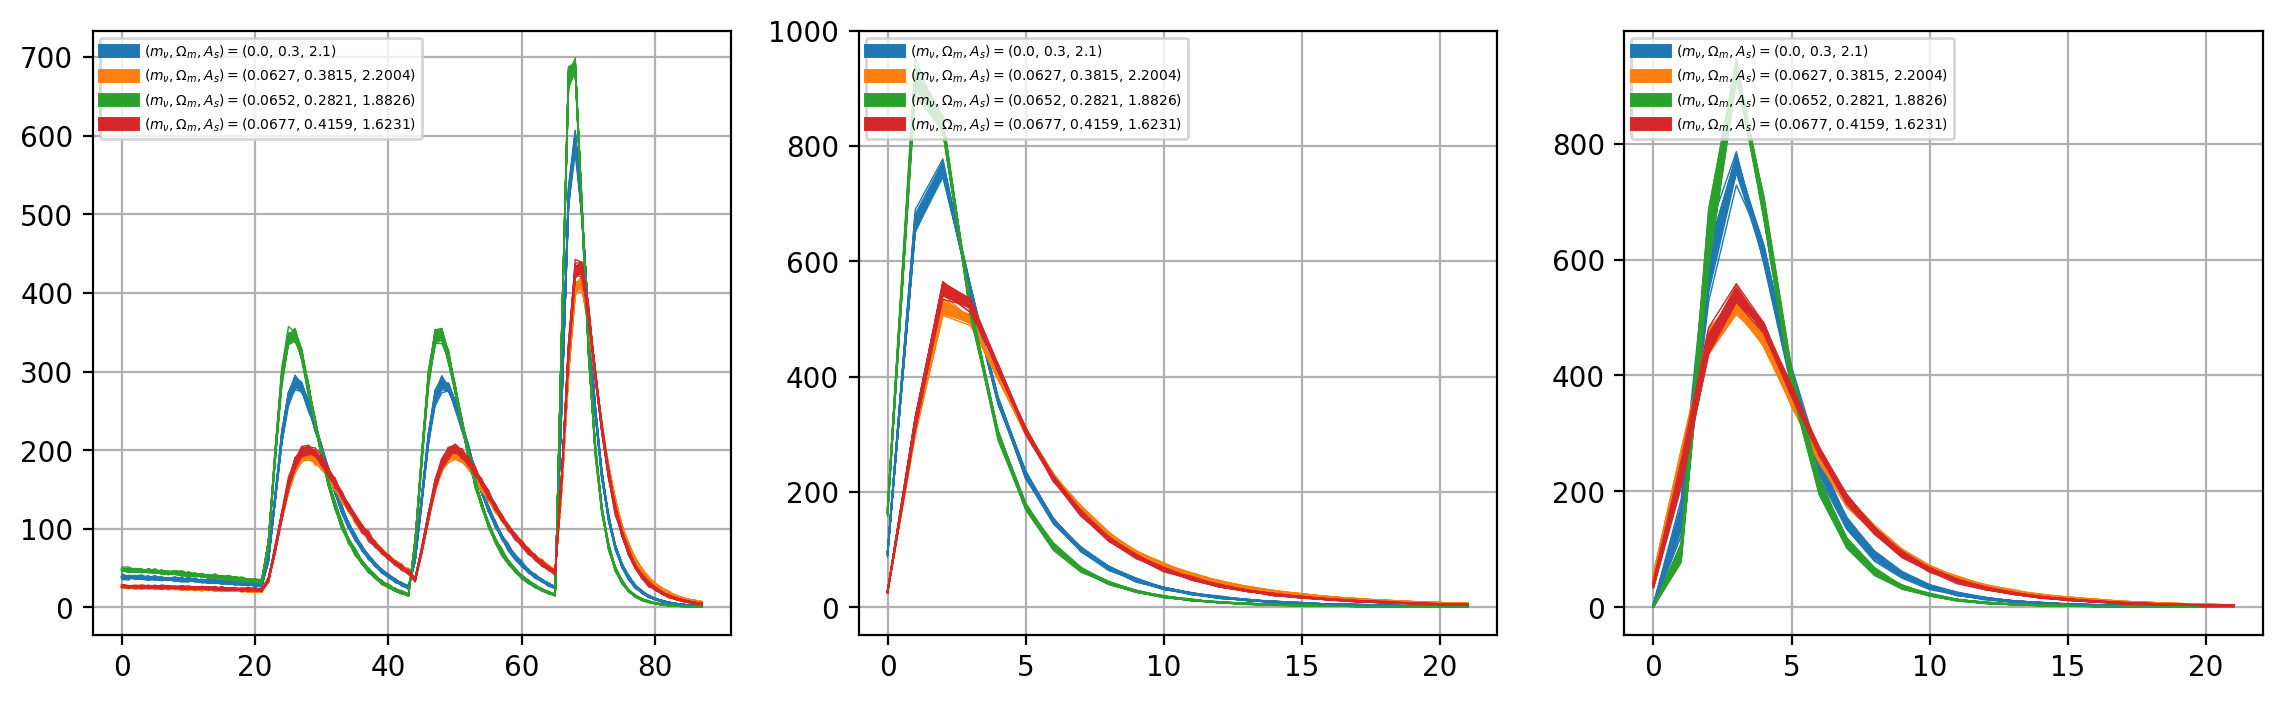

In [92]:
fig = plt.figure(figsize=(14,4), dpi=200)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
colors = ['C0', 'C1', 'C2', 'C3']

# histograms for wavelet
ax_00 = fig.add_subplot(spec[0, 0])
i = 0
for k in sorted(pcw.peak_list.keys()):
    param = (np.round(k[0], 4), np.round(k[1], 4), np.round(k[2], 4))
    if i <= 3:
        # empty plot for labels
        ax_00.plot([], lw=5, label=r'$(m_\nu,\Omega_m,A_s)=$'+str(param))
        for j in range(50):
            # plots
            hp = np.vstack(random.sample(pcw.peak_list[k], 30))
            ax_00.plot(np.mean(hp, axis=0), '-', lw=0.5, color=colors[i])
        i += 1
ax_00.legend(fontsize=5, loc='upper left', fancybox=True)            
ax_00.grid()

# histograms for laplace 
ax_01 = fig.add_subplot(spec[0, 1])
i = 0
for k in sorted(pcl.peak_list.keys()):
    param = (np.round(k[0], 4), np.round(k[1], 4), np.round(k[2], 4))
    if i <= 3:
        # empty plot for labels
        ax_01.plot([], lw=5, label=r'$(m_\nu,\Omega_m,A_s)=$'+str(param))
        for j in range(50):
            # plots
            hp = np.vstack(random.sample(pcl.peak_list[k], 30))
            ax_01.plot(np.mean(hp, axis=0), '-', lw=0.5, color=colors[i])
        i += 1
ax_01.legend(fontsize=5, loc='upper left', fancybox=True)            
ax_01.grid()

# histograms for peak height
ax_02 = fig.add_subplot(spec[0, 2])
i = 0
for k in sorted(pco.peak_list.keys()):
    param = (np.round(k[0], 4), np.round(k[1], 4), np.round(k[2], 4))
    if i <= 3:
        # empty plot for labels
        ax_02.plot([], lw=5, label=r'$(m_\nu,\Omega_m,A_s)=$'+str(param))
        for j in range(50):
            # plots
            hp = np.vstack(random.sample(pco.peak_list[k], 30))
            ax_02.plot(np.mean(hp, axis=0), '-', lw=0.5, color=colors[i])
        i += 1
ax_02.legend(fontsize=5, loc='upper left', fancybox=True)            
ax_02.grid()